In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVR, SVC, SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost

In [3]:
df = pd.read_csv("./data/data.csv")
df = df.copy()
data_raw = df.copy()

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [61]:
null_d = df[df["D_h [mm]"].isnull() & df["D_e [mm]"].isnull()]["id"]
df.drop(null_d, inplace=True, axis=0)

In [62]:
null_d

8            8
59          59
64          64
100        100
135        135
         ...  
31582    31582
31601    31601
31606    31606
31611    31611
31632    31632
Name: id, Length: 815, dtype: int64

In [67]:
(((11.6 ** 2) + (4*212*2)**1/2)-11.6)/4

242.73999999999998

In [7]:
target = df["x_e_out [-]"]

df = df.drop(columns=["author"])

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30829 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   30829 non-null  int64  
 1   author               25918 non-null  object 
 2   geometry             25475 non-null  object 
 3   pressure [MPa]       26504 non-null  float64
 4   mass_flux [kg/m2-s]  26144 non-null  float64
 5   x_e_out [-]          20673 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26202 non-null  float64
 9   chf_exp [MW/m2]      30829 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 3.6+ MB


In [9]:
true_target = target[target.notnull()]
true_target

0        0.1754
1       -0.0416
2        0.0335
3       -0.0279
5       -0.0711
          ...  
31636   -0.0195
31638   -0.0487
31639    0.0886
31641   -0.1224
31643    0.0603
Name: x_e_out [-], Length: 20673, dtype: float64

In [10]:
data = df[target.notnull()]

In [11]:
pd.set_option('display.max_rows', 20)

In [12]:
print(df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

geometry  D_e [mm]  D_h [mm]
tube      10.3      10.3        1880
          10.8      10.8        1790
          4.7       4.7         1754
          1.9       1.9         1723
          7.7       7.7         1642
                                ... 
          10.0      40.0           1
annulus   12.8      42.3           1
plate     10.8      10.8           1
          10.0      10.0           1
annulus   11.3      4.6            1
Name: id, Length: 89, dtype: int64


In [13]:
# print(data_raw.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

In [14]:
# df_aux = pd.DataFrame(data_raw.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count())
# df_aux.reset_index(inplace=True)
# sr = df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].max()
# sr_aux = pd.DataFrame(sr.sort_values(ascending=False).iloc[:30]).reset_index()
# sr_aux[sr_aux["geometry"]=="tube"].plot(y="D_h [mm]", x="D_e [mm]", kind="scatter", figsize=(10, 10))

In [15]:
df[df["D_h [mm]"]==df["D_e [mm]"]]

,id,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
1,1,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
4,4,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
6,6,NaN,6.89,549.0,0.1203,12.8,12.8,1930.0,2.6
7,7,tube,18.00,750.0,NaN,10.0,10.0,1650.0,2.2
...,...,...,...,...,...,...,...,...,...
31638,31638,tube,NaN,3648.0,-0.0487,4.7,4.7,318.0,9.0
31640,31640,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,31641,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,31642,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


In [16]:
df[df["D_e [mm]"].isnull()]["D_h [mm]"]

0        10.8
5         1.9
12       12.8
18       10.8
34        7.8
         ... 
31622     1.9
31629     4.7
31636     1.9
31637    11.1
31639     7.8
Name: D_h [mm], Length: 4673, dtype: float64

In [17]:
df[df["D_h [mm]"].isnull()]["D_e [mm]"].unique()

array([12.7, 10. ,  4.7,  1.9,  5.6,  3. ,  7.7,  5. , 23.6, 10.8, 11.5,
       15. , 10.3,  7.8, 11.1,  9.5,  4.6,  6.4,  8.5,  8. , 12.8,  9.3,
        1. ,  5.7, 22.2,  3.6, 37.5, 10.4,  1.1, 12.4, 23.5, 10.1, 19.8,
       10.7,  1.7, 23.7, 13.3])

In [18]:
df_aux = df[df["geometry"]=="plate"]
df_aux.dropna(inplace=True)
df_aux[df_aux ["D_e [mm]"] == df_aux ["D_h [mm]"]]

c:\Users\gylmo\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,id,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
4476,4476,plate,15.51,2984.0,-0.0109,1.9,1.9,10.0,7.6
6412,6412,plate,15.17,1335.0,-0.0187,9.5,9.5,1836.0,2.1
16858,16858,plate,0.51,2000.0,-0.0407,1.9,1.9,10.0,8.1
28605,28605,plate,0.51,5600.0,-0.0373,15.9,15.9,10.0,14.7


In [19]:
tube_error = 32/(6296+32)
annulus_error = 16/(1298+16)
plate_error = 4/(164+4)

print(f"tube error: {tube_error:.2}, annulus error: {annulus_error:.2}, plate error: {plate_error:.2}")

tube error: 0.0051, annulus error: 0.012, plate error: 0.024


Sabiendo esto, imputamos geometry, D_e y D_h sabiendo que: 
- si geometry = tube entonces D_e = D_h
- si geometry = plate entonces D_e = 15 | D_h = 120
- si geometry = annulus entonces LinearRegression

In [20]:
def value_changer(row):   
    if row["D_h [mm]"] == 120 or row["D_e [mm]"] == 15:
        row["geometry"] = "plate"
    elif row["D_e [mm]"] == row["D_e [mm]"]:
        row["geometry"] = "tube"
    elif row["geometry"] == "tube":
        row["D_e [mm]"] = row["D_e [mm]"]
    elif row["geometry"] == "plate":
        row["D_e [mm]"] = 15
        row["D_h [mm]"] = 120
    return row

df.apply(value_changer, axis=1)

,id,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,tube,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,tube,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...
31639,31639,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,31640,tube,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,31641,tube,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,31642,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30829 entries, 0 to 31643
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   30829 non-null  int64  
 1   geometry             25475 non-null  object 
 2   pressure [MPa]       26504 non-null  float64
 3   mass_flux [kg/m2-s]  26144 non-null  float64
 4   x_e_out [-]          20673 non-null  float64
 5   D_e [mm]             26156 non-null  float64
 6   D_h [mm]             27055 non-null  float64
 7   length [mm]          26202 non-null  float64
 8   chf_exp [MW/m2]      30829 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ MB


In [115]:
print(df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

geometry  D_e [mm]  D_h [mm]
tube      10.3      10.3        1880
          10.8      10.8        1790
          4.7       4.7         1754
          1.9       1.9         1723
          7.7       7.7         1642
annulus   5.6       15.2        1053
tube      7.8       7.8          913
          10.0      10.0         753
          9.5       9.5          604
annulus   12.7      42.3         585
tube      11.1      11.1         537
          23.6      23.6         445
          11.5      11.5         433
annulus   12.7      38.1         430
plate     15.0      120.0        420
tube      4.6       4.6          414
          5.6       5.6          388
          3.0       3.0          328
annulus   6.4       15.9         293
tube      5.7       5.7          269
annulus   8.5       22.3         255
tube      12.8      12.8         255
          37.5      37.5         194
          3.6       3.6          186
annulus   8.5       24.6         168
          5.0       13.3         128
tube     

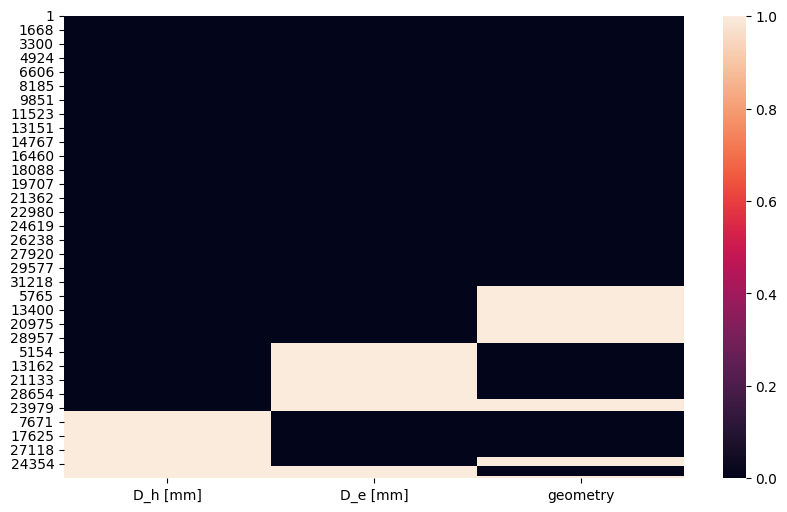

In [6]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(data_raw.loc[:,["D_h [mm]", "D_e [mm]", "geometry"]], cols_sort=["D_h [mm]", "D_e [mm]", "geometry"])